<a href="https://colab.research.google.com/github/ppaga/paper-explainers/blob/main/paper_explainer_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper explainer: Exact results on high-dimensional linear regression via statistical physics

Link to the paper: https://arxiv.org/pdf/2009.13229.pdf

## Some preliminaries: overfitting in high-dimensional linear regression

In [6]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from scipy.special import logit, expit
from numpy.random import randn, rand
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
%matplotlib inline

def LR_vars(**kwargs):

    X = np.random.randn(kwargs['N'],kwargs['theta'].shape[0])
    Y = np.matmul(X,kwargs['theta'])/np.sqrt(kwargs['theta'].shape[0]) + kwargs['sigma']*randn(kwargs['N'])

    return X,Y

N = int(1e4)
sigma = .5
alphas = [.01,.1,.2,.5,.9]

LR_key = namedtuple('LR_key',['N','alpha','sigma'])
def run_LR_simulation(N, sigma, alphas):
  experiments = {}
  for alpha in alphas:
    d = int(N*alpha)
    theta = randn(d)

    key = LR_key(N,alpha,sigma)

    X,Y = LR_vars(N=N, theta = theta, sigma = sigma)
    model = LinearRegression().fit(X,Y)
    theta_tilde = model.coef_
    Y_tilde = model.predict(X)
    experiments[key] = theta_tilde, theta
  return experiments
  

def plot_results(experiments):
  fig = plt.figure(figsize = (12,10))
  for key,val in experiments.items():
    theta_tilde, theta = val
    plt.scatter(theta, theta_tilde, s = 5)
  plt.legend([np.round(key.alpha, decimals=3) for key in experiments.keys()])

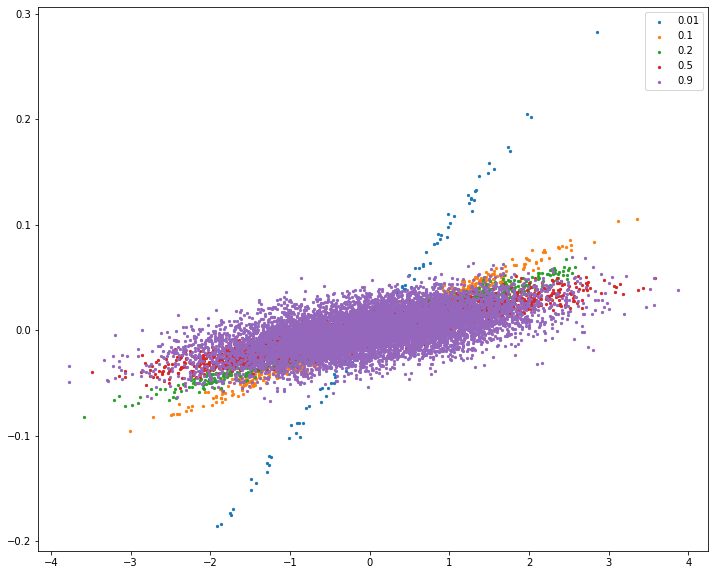

In [7]:
plot_results(experiments)